In [233]:
import pandas as pd
import numpy as np
import tensorflow as tf
from data_loader import load_veterans_ds, prepare_veterans_ds, load_cancer_ds, prepare_cancer_ds
from sklearn.preprocessing import StandardScaler
from utility import InputFunction, CindexMetric, CoxPHLoss, _make_riskset, _TFColor, sample_hmc, convert_to_structured
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pickle
from sksurv.metrics import integrated_brier_score

TFColor = _TFColor()
dtype = tf.float32

number_of_steps = 20000
number_burnin_steps = int(number_of_steps/10)

import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Load model chains
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
with open(f'{root_dir}/models/mcmc_chains.pkl', 'rb') as fp:
    chains = pickle.load(fp)
    
chains = [chain[0] for chain in chains] # leave out traces
    
# Make structured arrays
y_train_struc = convert_to_structured(t_train, e_train)
y_valid_struc = convert_to_structured(t_valid, e_valid)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [252]:
chain_index = 0
beta_index = 1
n_dims = chains[chain_index][beta_index].shape[2] # get n dims from first chain
chains_t = list(map(list, zip(*chains)))
chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]
alpha = tf.reduce_mean(chains_samples[0]).numpy().flatten()
betas = tf.reduce_mean(chains_samples[1], axis=0).numpy().flatten()

In [231]:
# Save alpha and betas from chain at index 0 TODO
chain_index = 0
alpha_index = 0
beta_index = 1

samples = chains[chain_index]
alphas = samples[alpha_index].numpy().flatten()[number_burnin_steps:] # skip burnin steps
n_dims = chains[chain_index][beta_index].shape[2]

X_train = np.array(X_train)[:,:n_dims]
X_valid = np.array(X_valid)[:,:n_dims]
X_test = np.array(X_test)[:,:n_dims]

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

betas = np.zeros((n_dims, number_of_steps-number_burnin_steps))
for i in range(n_dims):
    betas[i] = samples[beta_index][:,:,i].numpy().flatten()[number_burnin_steps:] # skip burnin steps

print(alphas.mean())
for beta in betas:
    print(beta.mean())

4.870606
-0.1380537713344739
0.1373677933818027
-0.47008822866653405
0.3975523654143843
0.7777853783518076
-0.04840691775369406
0.2261286201086154
0.13139577982789746


In [214]:
np.exp(alphas.mean())

130.3263

In [215]:
lambda_mean, lambda_std = np.exp(alphas.mean()), np.exp(alphas.std())
mean_obs_time = y_train[y_train['Status']==False]['Survival_in_days'].mean()
print(f"mean/std lambda: {np.around(float(lambda_mean), 2)} (+-{np.around(float(lambda_std), 2)})")
print(f"mean obs time: {mean_obs_time}")

mean/std lambda: 130.33 (+-1.04)
mean obs time: 131.28571428571428


In [216]:
mean_alpha = alphas.mean()
mean_betas = betas.mean(axis=1)

np.exp(mean_alpha + X_valid @ mean_betas)

array([  36.14943403,  472.46085898,  121.189837  ,   65.92394909,
        201.7267667 ,   60.08200015,  117.22531718,   11.2798323 ,
        221.43823371,  456.48293716,  149.69276656,  197.21791829,
         45.18601205,   61.0016869 ,   65.7470249 ,  132.66400938,
        335.95931868,  102.41183361,  620.79124491, 1037.51575678,
         23.89976081])

In [217]:
# Make predictions on valid dataset (ignore the uncertainity)
mean_alpha = tf.math.reduce_mean(alphas, axis=0).numpy()
mean_betas = tf.math.reduce_mean(betas, axis=1).numpy()

predict_func = lambda data: np.exp(mean_alpha + np.dot(mean_betas, np.transpose(data)))
valid_preds = np.zeros((len(X_valid)))
for i, data in enumerate(X_valid):
    valid_preds[i] = predict_func(data)

In [218]:
print(t_valid)

[ 22.  30.  19.  61. 156.  24.  12.  18. 314. 110. 177.  36.   2. 153.
  31.  54.   1. 117. 340. 389. 151.]


In [219]:
print([round(float(pred)) for pred in valid_preds])

[36, 472, 121, 66, 202, 60, 117, 11, 221, 456, 150, 197, 45, 61, 66, 133, 336, 102, 621, 1038, 24]


In [220]:
# Calculate C-index using negative event times as risk
from sksurv.metrics import concordance_index_censored
results = concordance_index_censored(e_valid, t_valid, -valid_preds)[0]
print(results)

0.6666666666666666


In [221]:
# Calculate Brier score
lower, upper = np.percentile(t_valid[t_valid.dtype.names], [10, 90])
times = np.arange(lower, upper+1)

estimate = np.zeros((len(X_valid), len(times)))
for i, data_obs in enumerate(X_valid):
    pred_lambda = predict_func(data)
    surv_prob = np.exp(-times/pred_lambda)
    estimate[i] = surv_prob

integrated_brier_score(y_train_struc, y_valid_struc, estimate, times)

0.27665252916934263

Text(0, 0.5, 'Density')

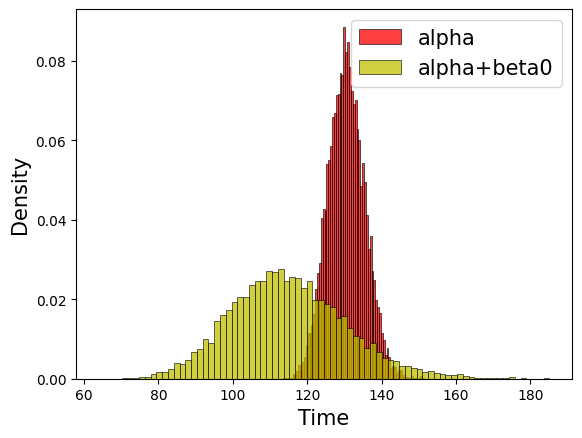

In [222]:
# Calculate log rate as log lambda = a+bX 
lambda_no_beta = np.exp(alphas)
lambda_beta0 = np.exp(alphas + betas[0])
#lambda_beta1 = np.exp(alphas + betas[1])
#lambda_beta2 = np.exp(alphas + betas[2])

# Plot distributions with various betas used. Notice the shift in risk (normalized)
sns.histplot(lambda_no_beta, color='r', stat='density', label='alpha')
sns.histplot(lambda_beta0, color='y', stat='density', label='alpha+beta0')
#sns.histplot(lambda_beta1, color='b', stat='density', label='alpha+beta1')
#sns.histplot(lambda_beta2, color='m', stat='density', label='alpha+beta2')
plt.legend(fontsize=15)
plt.xlabel("Time", size=15)
plt.ylabel("Density", size=15)

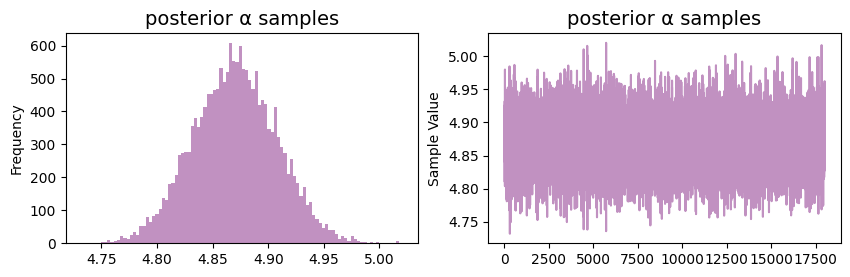

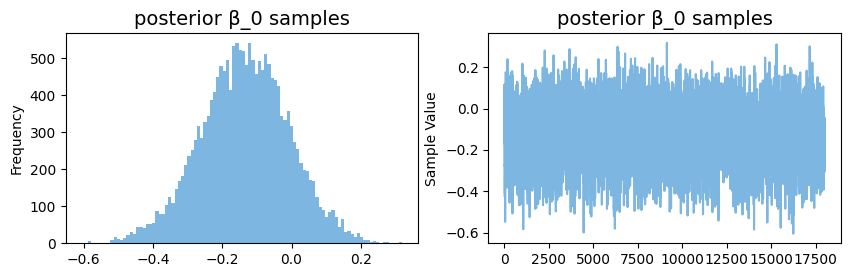

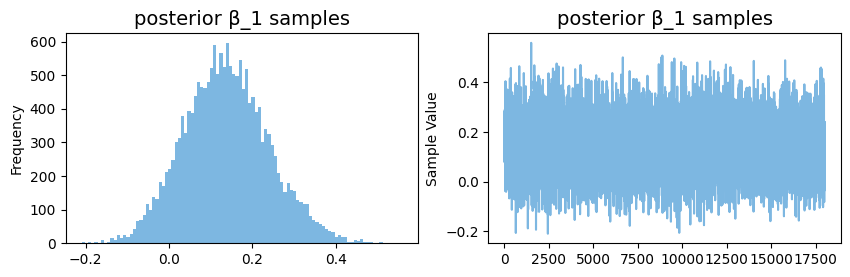

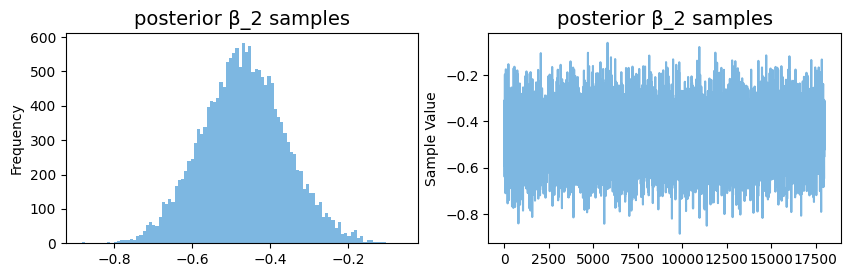

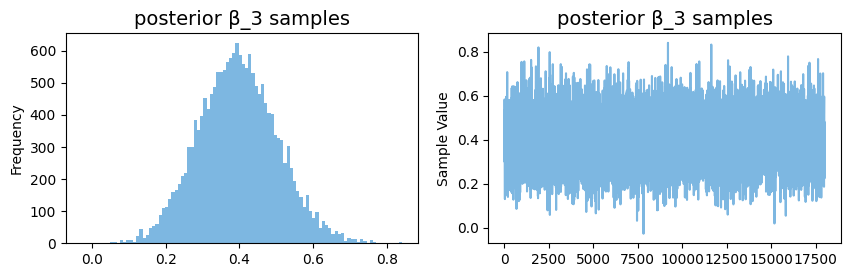

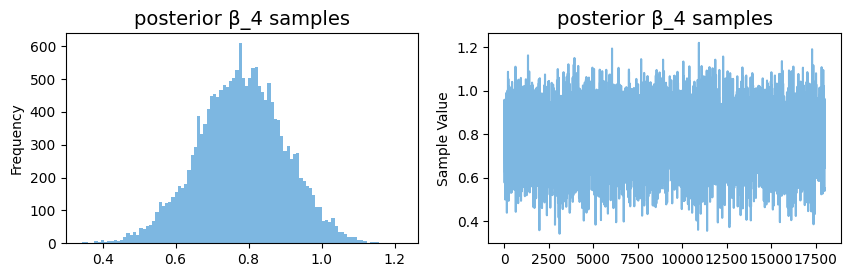

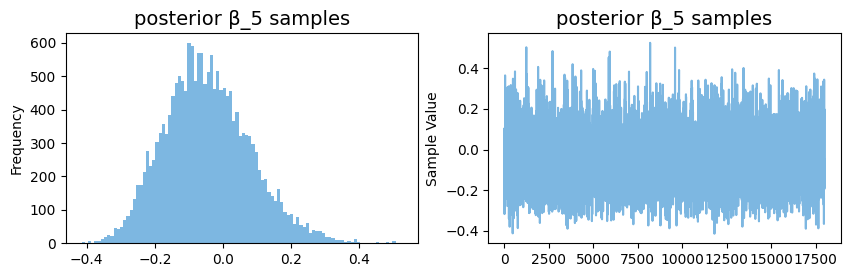

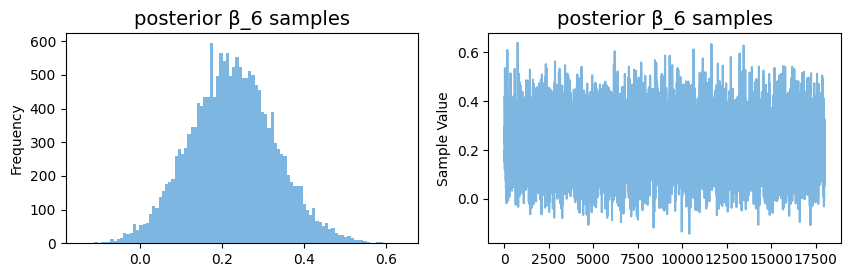

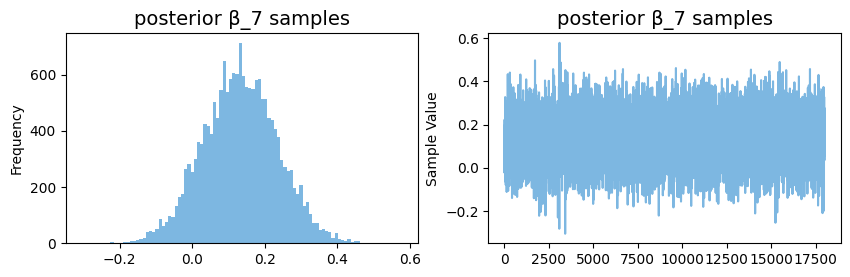

In [223]:
# Plot the posterior samples
 
plt.figure(figsize=(10,6))
plt.subplot(2, 2, 1)
plt.hist(alphas, bins=100, color=TFColor[6], alpha=0.8)
plt.ylabel('Frequency')
plt.title('posterior α samples', fontsize=14)

plt.subplot(2, 2, 2)
plt.plot(np.arange(number_of_steps-number_burnin_steps), alphas, color=TFColor[6], alpha=0.8)
plt.ylabel('Sample Value')
plt.title('posterior α samples', fontsize=14)

for i in range(n_dims):
    plt.figure(figsize=(10,6))
    plt.subplot(2, 2, 1)
    plt.hist(betas[i], bins=100, color=TFColor[3], alpha=0.8)
    plt.ylabel('Frequency')
    plt.title(f'posterior β_{i} samples', fontsize=14)

    plt.subplot(2, 2, 2)
    plt.plot(np.arange(number_of_steps-number_burnin_steps), betas[i], color=TFColor[3], alpha=0.8)
    plt.ylabel('Sample Value')
    plt.title(f'posterior β_{i} samples', fontsize=14)

In [224]:
chains_t = list(map(list, zip(*chains)))

chains_samples = [tf.squeeze(tf.concat(samples, axis=0)) for samples in chains_t]

In [230]:
chains_samples

[<tf.Tensor: shape=(100000,), dtype=float32, numpy=
 array([4.8606   , 4.857512 , 4.8603773, ..., 4.9623017, 4.8295918,
        4.8295918], dtype=float32)>,
 <tf.Tensor: shape=(100000, 8), dtype=float32, numpy=
 array([[-0.12287213,  0.39779037, -0.37739667, ...,  0.08060093,
          0.1205249 ,  0.08424589],
        [-0.25851133,  0.18988486, -0.42637083, ...,  0.07452662,
          0.4137215 , -0.06065124],
        [-0.42397   ,  0.32967544, -0.35900405, ...,  0.01957782,
          0.36608487,  0.0763153 ],
        ...,
        [-0.05865784, -0.03456574, -0.5209297 , ...,  0.19709505,
          0.30283344,  0.27590364],
        [-0.17185186,  0.23966992, -0.38953793, ...,  0.17168137,
          0.23726094,  0.07979719],
        [-0.17185186,  0.23966992, -0.38953793, ...,  0.17168137,
          0.23726094,  0.07979719]], dtype=float32)>]

In [225]:
chains_df = pd.concat(
    objs=[pd.DataFrame(samples.numpy()) for samples in chains_samples], 
    axis=1
)

params = ['alpha'] + [f'beta_{i}' for i in range(n_dims)]
chains_df.columns = params

chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % number_of_steps,
        chain_id=lambda x: (x['sample_id'] / number_of_steps).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str)) \
    

chains_df.head()

,alpha,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,sample_id,chain_sample_id,chain_id
0,4.860600,-0.122872,0.397790,-0.377397,0.569626,0.855251,0.080601,0.120525,0.084246,0,0,c_1
1,4.857512,-0.258511,0.189885,-0.426371,0.567356,0.763915,0.074527,0.413722,-0.060651,1,1,c_1
2,4.860377,-0.423970,0.329675,-0.359004,0.438500,0.599766,0.019578,0.366085,0.076315,2,2,c_1
3,4.860377,-0.423970,0.329675,-0.359004,0.438500,0.599766,0.019578,0.366085,0.076315,3,3,c_1
4,4.878060,-0.142058,0.233634,-0.291858,0.733411,0.675998,-0.035075,0.103787,0.095582,4,4,c_1


Text(0.5, 1.03, 'Posterior Samples per Chain')

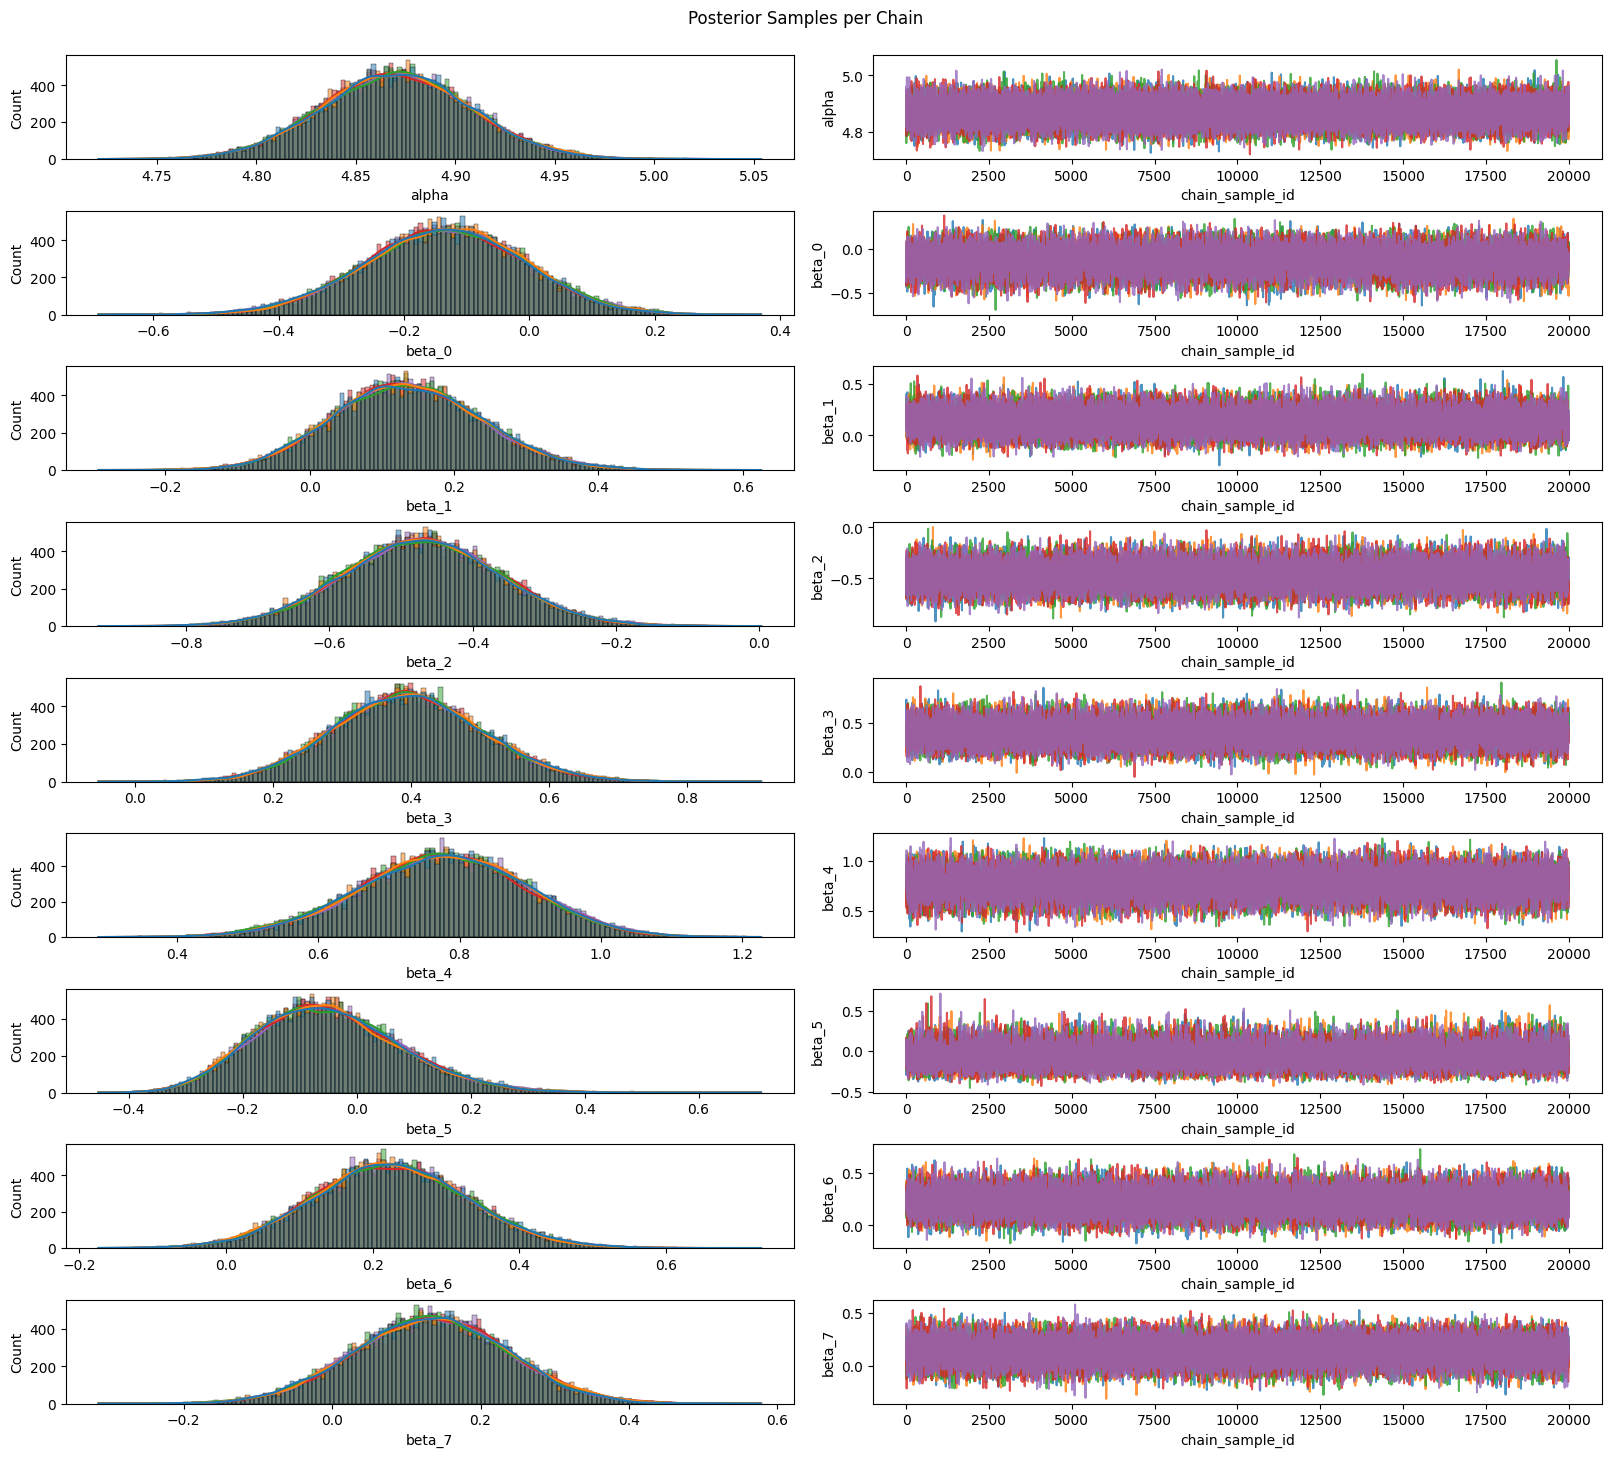

In [227]:
fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(16, 14), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0], legend=False)
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.8, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Text(0.5, 1.03, 'Posterior Samples')

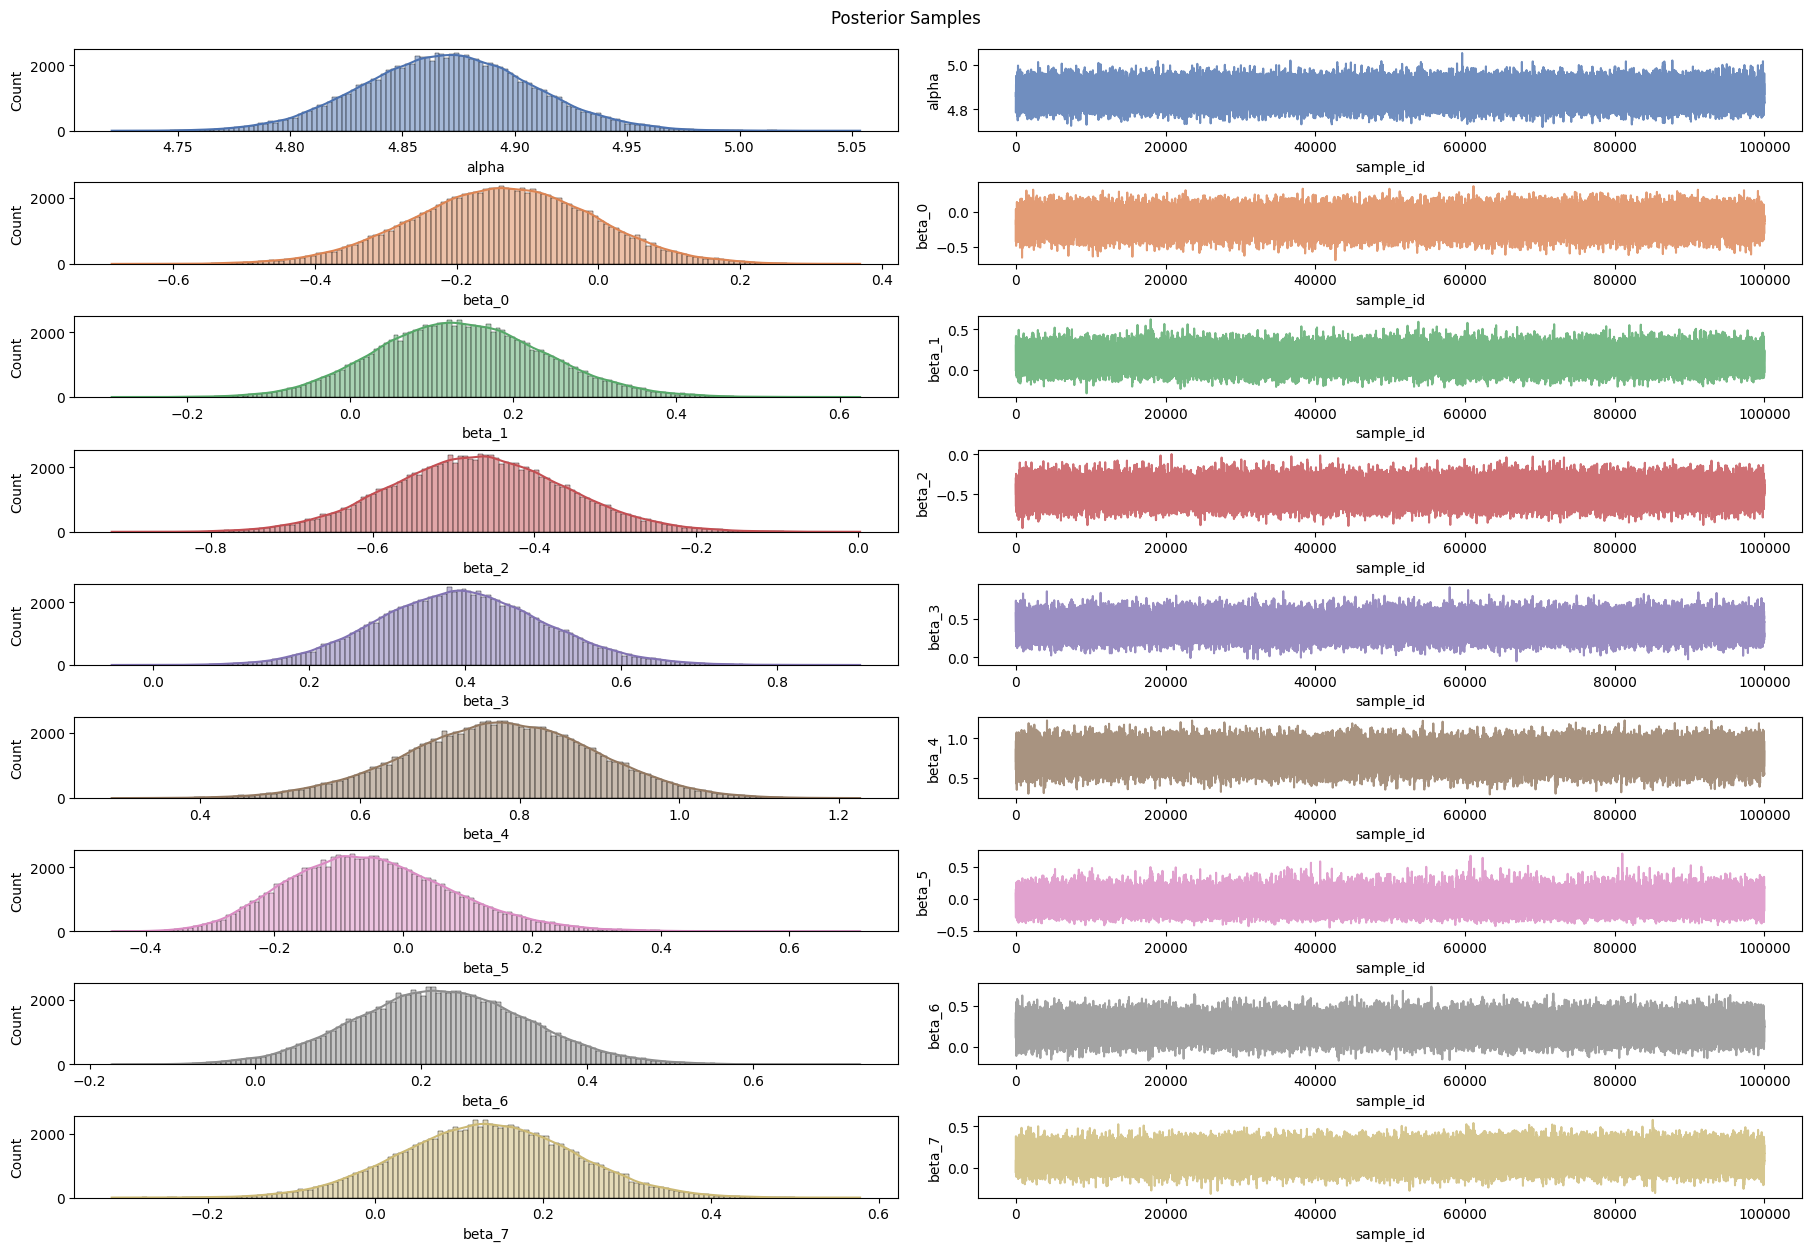

In [229]:
sns_c = sns.color_palette(palette='deep')

fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(18, 12), constrained_layout=True)

for i, param in enumerate(params):
    sns.histplot(x=param, data=chains_df, color=sns_c[i], kde=True, ax=axes[i][0])
    sns.lineplot(x='sample_id', y=param, data=chains_df, color=sns_c[i], alpha=0.8, ax=axes[i][1])

fig.suptitle('Posterior Samples', y=1.03)

In [496]:
size = 100
x0 = np.random.randn(size)
x1 = np.random.randn(size)
x = np.stack([x0], axis=1)
x = tf.convert_to_tensor(x, dtype=dtype)

In [497]:
# Here we compute mu = alpha + beta x. #TODO: Needs to fit surv analysis exp(alpha +beta*x)
mu_posterior_samples = tf.linalg.matmul(tf.reshape(chains_samples[0], (-1, 1)), tf.ones(shape=(1, x_obs.shape[0]))) \
    + tf.linalg.matmul(tf.reshape(chains_samples[1], (-1, 1)), tf.transpose(x_obs))

NameError: name 'x_obs' is not defined

In [ ]:
mu_posterior_mean = tf.math.reduce_mean(mu_posterior_samples, axis=0).numpy()
mu_posterior_std = tf.math.reduce_std(mu_posterior_samples, axis=0).numpy()

NameError: name 'mu_posterior_samples' is not defined

In [ ]:
random_guess = tf.convert_to_tensor(np.random.uniform(0, 10, size=(len(y_preds), 1)).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
train_event_set = tf.expand_dims(e_train.astype(np.int32), axis=1)
train_risks_set = tf.convert_to_tensor(_make_riskset(t_train))
y_pred = tf.convert_to_tensor(y_preds.reshape(len(y_preds), 1).astype(np.float32))

NameError: name 'y_preds' is not defined

In [ ]:
mcmc_train_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=y_pred)
random_guess_loss = loss_fn(y_true=[train_event_set, train_risks_set], y_pred=random_guess)
print(f"MCMC loss {mcmc_train_loss}, random: {random_guess_loss}")